In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [10]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Embedding, GlobalAveragePooling1D, Bidirectional, LSTM, \
    BatchNormalization, Conv1D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential


In [11]:
# setting global variables
dbBase = r"refined_dataset"
save_path = r"C:\Users\mhasa\AppData\Roaming\Autodesk\Autodesk Fusion 360\MyScripts\PureFlask_3JS_server\flask_app\nlp_model"

all_sentences = []
all_labels = []

In [12]:
# reading the words from file and creating a dataset
types = ['bearing', 'bolt', 'collet', 'spring', 'sprocket']
class_num = len(types)

for label, type in enumerate(types):

    with open(f"{dbBase}//{type}_100.txt", mode='r') as partFile:
        content = partFile.readlines()
        content = [c.replace("\n", "") for c in content]

        all_sentences.extend(content)
        all_labels.extend([label] * len(content))

all_sentences = np.array(all_sentences)
all_labels = np.array(all_labels)

In [13]:
# binarize the labels
le = LabelBinarizer()
all_labels = le.fit_transform(all_labels)

In [14]:
epoch_no = 50
vocab_size = 350
embedding_dim = 50
max_length = 4
trunc_type = "post"
oov_tok = "<OOV>"
test_size = 0.3

In [15]:
# do a trin test split
train_sentences, \
test_sentences, \
trainy, \
testy = train_test_split(all_sentences,
                         all_labels,
                         stratify=all_labels,
                         test_size=test_size,
                         random_state=42)


In [16]:
# tokenize the train set
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                       truncating=trunc_type)
# tokenise and pad the test set
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# check out the word index
print(len(tokenizer.word_index.keys()))
print(tokenizer.word_index)

397
{'<OOV>': 1, 'holder': 2, 'elastic': 3, 'roller': 4, 'workpiece': 5, 'centering': 6, 'screw': 7, 'energy': 8, 'gear': 9, 'tool': 10, 'self': 11, 'chain': 12, 'rod': 13, 'threaded': 14, 'element': 15, 'rear': 16, 'jaw': 17, 'wheel': 18, 'chuck': 19, 'harmonic': 20, 'clamping': 21, 'coil': 22, 'hex': 23, 'helical': 24, 'bearings': 25, 'member': 26, 'shafts': 27, 'pinion': 28, 'derailleur': 29, 'machine': 30, 'tensioner': 31, 'piston': 32, 'gears': 33, 'radial': 34, 'shaft': 35, 'belt': 36, 'component': 37, 'compression': 38, 'fixture': 39, 'wrench': 40, 'brake': 41, 'holding': 42, 'taper': 43, 'driven': 44, 'hydraulically': 45, 'valves': 46, 'lever': 47, 'mechanism': 48, 'bolts': 49, 'tension': 50, 'spring': 51, 'fastener': 52, 'spherical': 53, 'concentric': 54, 'joiner': 55, 'hydraulic': 56, 'torque': 57, 'springs': 58, 'gripper': 59, 'speed': 60, 'hold': 61, 'bolt': 62, 'allen': 63, 'extension': 64, 'suspension': 65, 'gearbox': 66, 'shock': 67, 'absorber': 68, 'outer': 69, 'sleeve'

In [17]:
# now construct the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length))

# change here
#model.add(Flatten())

# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(64)))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())

# change ends here
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=class_num, activation="softmax"))

# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer = 'adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 50)             17500     
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            19328     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 41,249
Trainable params: 41,185
Non-trainable params: 64
___________________________________________________

In [18]:
H = model.fit(padded_train_sequences,
          trainy,
          epochs=epoch_no,
          validation_data=(padded_test_sequences, testy))

Train on 420 samples, validate on 180 samples
Epoch 1/50
420/420 [==============================] - 2s 4ms/sample - loss: 1.5231 - accuracy: 0.3286 - val_loss: 1.5976 - val_accuracy: 0.3889
Epoch 2/50
420/420 [==============================] - 0s 128us/sample - loss: 1.1031 - accuracy: 0.7000 - val_loss: 1.5806 - val_accuracy: 0.5111
Epoch 3/50
420/420 [==============================] - 0s 117us/sample - loss: 0.7618 - accuracy: 0.8119 - val_loss: 1.5533 - val_accuracy: 0.6500
Epoch 4/50
420/420 [==============================] - 0s 124us/sample - loss: 0.4830 - accuracy: 0.8738 - val_loss: 1.5203 - val_accuracy: 0.6667
Epoch 5/50
420/420 [==============================] - 0s 126us/sample - loss: 0.3300 - accuracy: 0.9238 - val_loss: 1.4907 - val_accuracy: 0.6944
Epoch 6/50
420/420 [==============================] 

In [19]:
epochs = range(1,epoch_no+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

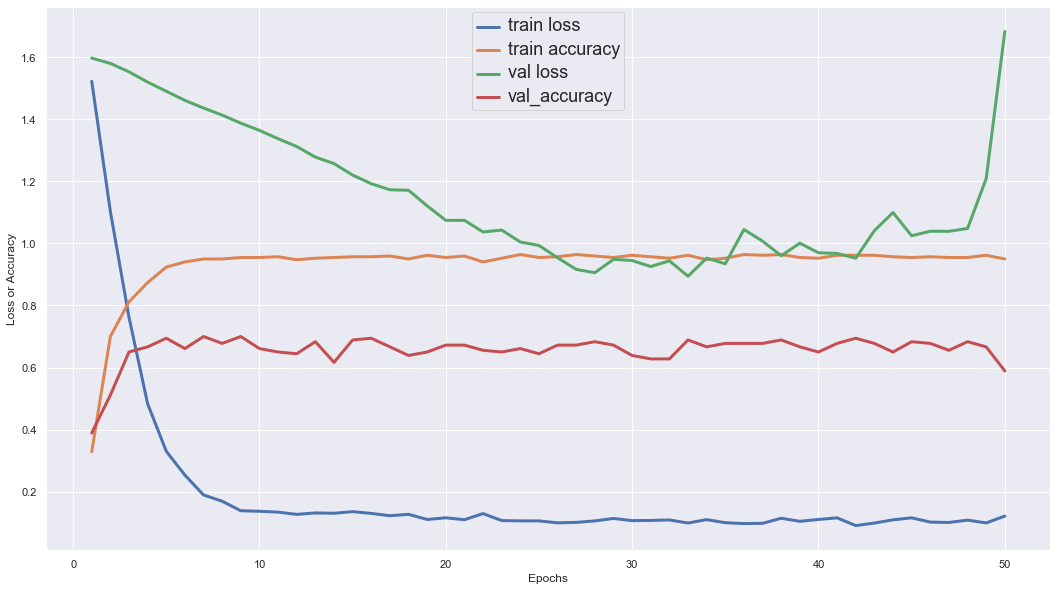

In [20]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [21]:
# save the model
save_path = r"C:\Users\mhasa\AppData\Roaming\Autodesk\Autodesk Fusion 360\MyScripts\PureFlask_3JS_server\flask_app\nlp_model"
model.save(f"{save_path}\\nlp_model.h5", overwrite=True)

In [22]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(350, 50)


In [23]:
reverse_word_index = dict([(val, key)
                           for (key, val) in tokenizer.word_index.items()])

In [24]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [25]:
# save my embedding matrix
out_e = io.open('embed_matrix.txt', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_str = word + '\t' + '\t'.join([str(x) for x in embeddings]) + "\n"
  out_e.write(out_str)
out_e.close()

In [26]:
padded_train_sequences

array([[  0, 170,  36,  37],
       [  0,   0,   0,  84],
       [  0,   0,   0, 171],
       ...,
       [  0,   0,  20,   1],
       [  0,   0,  28,  33],
       [  0,   0, 169,  33]])

In [27]:
import pickle

# saving
with open(f'{save_path}//tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
# loading the tokenizer
import pickle
save_path = r"C:\Users\mhasa\AppData\Roaming\Autodesk\Autodesk Fusion 360\MyScripts\PureFlask_3JS_server\flask_app\nlp_model"

with open(f'{save_path}//tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [29]:
loaded_model = load_model(f"{save_path}//nlp_model.h5")

In [30]:
sample_text = ["flexible absorbs shocks"]
sample_text_array = np.asarray(sample_text)

In [31]:
sample_text_sequence = loaded_tokenizer.texts_to_sequences(sample_text_array)
padded_sample_sequence = pad_sequences(sample_text_sequence, maxlen=4)
padded_sample_sequence

array([[0, 1, 1, 1]])

In [32]:
types = ['Bearings', 'Bolts', 'Collets', 'Springs', 'Sprockets']
pred = loaded_model.predict(padded_sample_sequence)
index = np.argmax(pred)
queried_part = types[int(index)]
print(f"Queried part is: {queried_part}")

Queried part is: Collets
